In [1]:
# Code that helps avoid overusing memory

import tensorflow as tf
tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True
sess = tf.Session(config=tf_config)
from keras import backend as K
K.set_session(sess)

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#Importing the VAE and RNN.
import os
import sys

#Adding WorldModels path to pythonpath
nb_dir = os.path.split(os.getcwd())[0]
print(nb_dir)
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
#Importing the VAE
from VAE.world_model_vae import VAE
from RNN.world_model_rnn import RNN
import mdn

/home/kaiolae/workspace/world_models/WorldModels


In [3]:
LATENT_SPACE_DIMENSIONALITY = 16
NUM_MIXTURES = 5

In [4]:
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import display, HTML


def plot_movie_mp4(image_array):
    dpi = 2.0
    #xpixels, ypixels = image_array[0].shape[0], image_array[0].shape[1]
    #fig = plt.figure(figsize=(ypixels/dpi, xpixels/dpi), dpi=dpi)
    fig = plt.figure(figsize=(1,1), dpi=dpi)
    im = plt.figimage(image_array[0])

    def animate(i):
        im.set_array(image_array[i])
        return (im,)

    anim = animation.FuncAnimation(fig, animate, frames=len(image_array))
    display(HTML(anim.to_html5_video()))

In [5]:
#Loading Weights of trained VAE and RNN
vae = VAE()
vae.set_weights("../models/final_full_vae_weights.h5")

rnn = RNN()
rnn.set_weights("../rnn-model/rnn_trained_model.h5")

VAE init
Shape before flattening: (None, 16, 16, 32)
KL Shape: (None,)
Xent shape: ()
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 3)    39          encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 32)   416         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 16, 16, 32)   4128        conv2d_2[0][0]                   
_______________________

In [6]:
#Get a start video
#Getting data to feed into the VAE and RNN
import numpy as np
data = np.load("../rnn-data/rnn_training_data.npz")
action_file = data['action']
latent_file = data['latent']

single_action_sequence = action_file[2]
single_latent_sequence = latent_file[2]
print("Actions length: ", len(single_action_sequence))
print("Latent vectors length: ", len(single_latent_sequence))




#Decode all 100 vectors, store as video
#Visualize video.

Actions length:  300
Latent vectors length:  300


In [7]:
#Decode a sequence with the VAE and visualize it
def decode_and_visualize(latent_vector_sequence):
    reconstructions = vae.decoder.predict(np.array(latent_vector_sequence))
    plot_movie_mp4(reconstructions)

### Visualizing one sequence of latent vectors from the training data

In [8]:
decode_and_visualize(single_latent_sequence)

### Starting with one z-vector, unroll that N steps into the future, storing all

In [19]:
#For now, testing with REAL z-and a input each time. Later: Test longer-term prediciton.
rnn_input_sequence = []
for timestep in range(len(single_latent_sequence)):
    rnn_input_sequence.append(np.concatenate([single_latent_sequence[timestep], [single_action_sequence[timestep]]]))
#Predict next z-vector, 100 times - storing all.
#Input: Last 30 timesteps. Output: next predicted image.
#TODO: Set up something like the startrek RNN, which could decode
#1-to-1 by having internal state.
#Slicing Input sequence into overlapping length 30 pieces
step_size = 1
seq_size = 30
rnn_input_data = []
for j in range(0, len(rnn_input_sequence)-seq_size, step_size):
    rnn_input_data.append(rnn_input_sequence[j:j+seq_size])

rnn_input_data = np.array(rnn_input_data)
print("Input shape: ", rnn_input_data.shape)
rnn_input_data = np.array(rnn_input_data)
mdn_outputs = rnn.model.predict(rnn_input_data)
#for input in rnn_input_sequence:
#    prediction = rnn.model.predict(input)
#    rnn_input_sequence.append(prediction)
mdn_outputs = np.array(mdn_outputs)
print("Output shape: ", mdn_outputs.shape)

Input shape:  (270, 30, 17)
Output shape:  (270, 165)


In [37]:
#Sampling from the generated MDN models, to generate latent 
#vectors.
#TODO Decide what sampling temperature to use. 1 seems reasonable?
generated_latent_vectors = []
for mdn_timestep in mdn_outputs:
    sampled_latent = mdn.sample_from_output(mdn_timestep,LATENT_SPACE_DIMENSIONALITY,
                                           NUM_MIXTURES, temp=0.5)
    generated_latent_vectors.append(sampled_latent[0])
generated_latent_vectors = np.array(generated_latent_vectors)
print("Sampled latent vectors shape: ", generated_latent_vectors.shape)

Sampled latent vectors shape:  (270, 16)


In [38]:
#Decoding the sampled latent vectors into images, and visualizing
decode_and_visualize(single_latent_sequence)
decode_and_visualize(generated_latent_vectors)


Current image: 


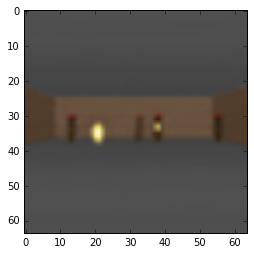

Predicted future: 


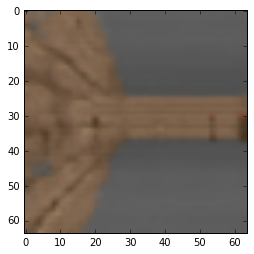

In [40]:
#How do I show current step and predicted next step nicely side-by-side?
TIMESTEP = 108
decoded_current = vae.decoder.predict(single_latent_sequence)
decoded_future = vae.decoder.predict(generated_latent_vectors)
print("Current image: ")
plt.imshow(decoded_current[TIMESTEP])
plt.show()
print("Predicted future: ")
plt.imshow(decoded_future[TIMESTEP])
plt.show()

In [36]:
#How can I plot the current and predicted latent vectors side-
#by-side?
for timestep in range(len(generated_latent_vectors)):
    print("Current: ", single_latent_sequence[timestep])
    print("Predicted: ", generated_latent_vectors[timestep])

Current:  [-0.10380113 -0.12192726 -0.06675352  0.2137468  -0.3639959  -0.11816651
  0.55367965  0.24266453  1.4254695  -0.5789901  -0.09050075  0.08594902
  0.40015292 -0.0998565  -0.7477255   0.12058069]
Predicted:  [ 0.07526718  0.22864158 -0.16161875  0.22074704 -0.30120122  0.21686301
  0.32698797  0.21807664  0.02665947  0.09071731 -0.24849303  0.27016343
 -0.19298802 -0.19114405  0.18723081 -0.33816088]
Current:  [-0.10380113 -0.12192726 -0.06675352  0.2137468  -0.3639959  -0.11816651
  0.55367965  0.24266453  1.4254695  -0.5789901  -0.09050075  0.08594902
  0.40015292 -0.0998565  -0.7477255   0.12058069]
Predicted:  [ 0.30753118  0.19220663 -0.31668869  0.14203306 -0.3086148   0.23671591
  0.34528977  0.31565187  0.09038973  0.169584   -0.27092426  0.40193952
 -0.04485505 -0.27567855  0.20760442 -0.42171278]
Current:  [-0.12595254 -0.07717121 -0.03921837  0.17043568 -0.3665949  -0.141839
  0.74871224  0.2476825   1.4167293  -0.5767455  -0.2774155   0.0787266
  0.22834249 -0.048